# Random Forests Trading
A raondom forest model is trained on technical indicators about a stock to try to predict whether it will rise or fall.

## Data Aquisition
Data aquired from Alpha Vantage using [this](https://github.com/RomelTorres/alpha_vantage) API wrapper, is loaded in. 

In [1]:
import get_data

symbol = 'AAPL'

data = get_data.get_data(symbol)
data = data.sort_values('date')
data.head()

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient,Chaikin A/D,ADOSC,...,FastK,FastD,T3,TEMA,TRANGE,TRIMA,TRIX,ULTOSC,WILLR,WMA
date,,,,,,,,,,,,,,,,,,,,,
2000-07-13,58.50,60.63,54.75,56.50,3.5111,7958200.0,0.0,1.0,-6.993677e+06,1.197934e+06,...,51.4118,74.5177,63.2028,50.3987,5.88,57.3068,-1.4884,49.2928,-87.3504,56.5547
2000-07-14,57.13,59.00,56.88,57.69,3.5850,3397800.0,0.0,1.0,-7.795045e+06,5.674957e+05,...,57.2674,68.2777,61.4367,51.3243,2.50,55.9240,-1.5015,52.9064,-85.1593,56.1104
2000-07-17,58.25,58.81,57.13,58.31,3.6236,4642900.0,0.0,1.0,-5.915776e+06,8.559479e+05,...,60.5442,56.4078,59.8141,52.3390,1.68,54.9689,-1.5067,52.5066,-84.0177,55.8904
2000-07-18,58.50,58.88,56.88,57.25,3.5577,5685800.0,0.0,1.0,-9.497830e+06,-2.436069e+05,...,42.5170,53.4429,58.3382,52.9791,2.00,54.4025,-1.5060,48.7458,-85.9694,55.7260
2000-07-19,55.19,56.81,51.75,52.69,3.2743,8176300.0,0.0,1.0,-1.463630e+07,-2.306245e+06,...,10.5856,37.8823,56.9920,52.3944,5.50,54.2394,-1.5045,39.9646,-72.1818,55.3147


## Data Preprocessing
The data is preprocessed so that is can be used by `sklearn`. We begin by adding a column to `data` for the label. The label will be 1 if the price went up the next day of 0 if it went down.

In [2]:
import numpy as np

cl = data['5. adjusted close'].values
ncl = cl[1:]

sign = (ncl - cl[:-1] > 0).astype(int)

data = data.iloc[:-1]
data['Price Direction'] = sign

X = data.loc[:, :'WMA']
y = data.loc[:, 'Price Direction']

test = data.loc['2011':'2020']
Xtest = test.loc[:, :'WMA']
ytest = test.loc[:, 'Price Direction']

train = data.loc[:'2010']
Xtrain = train.loc[:, :'WMA']
ytrain = train.loc[:, 'Price Direction']

## Modeling
A random forest is trained on the data.

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rfc = RandomForestClassifier(n_jobs=-1)
gd_sr = GridSearchCV(estimator=rfc,
                    param_grid={'n_estimators': [150, 100, 150, 200],
                               'criterion': ['gini', 'entropy'],
                               'max_features': ['auto', 'sqrt', 'log2', None]},
                    verbose=2,
                    n_jobs=-1)

gd_sr.fit(Xtrain.values, ytrain.values)
gd_sr.best_params_

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:  5.8min finished


{'criterion': 'gini', 'max_features': 'auto', 'n_estimators': 150}

## Model Evaluation
The model is evaluated on the test data

In [4]:
model = gd_sr.best_estimator_
acc = model.score(Xtest, ytest) * 100

print(f'The model had an accurracy of {acc} % on the test data.')

The model had an accurracy of 51.40105078809106 % on the test data.


## Simulated Trading
The model is used to simulate trading in 2019 and 2020.

The ROI of the alogrithim is 3917.312321476528 %, when a buy and hold strategy had an ROI of 690.6789385024778 %.


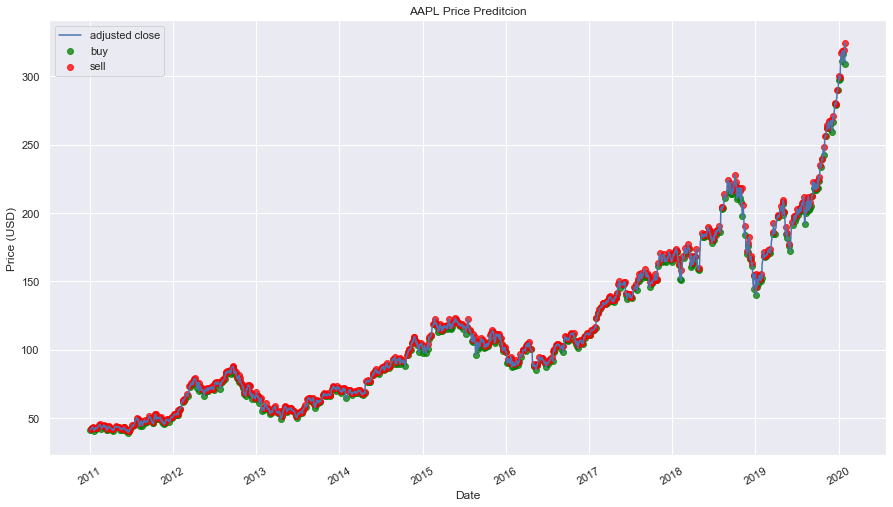

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

buy = np.zeros_like(ytest.values, dtype=bool)
sell = buy.copy()

d = Xtest.index
p = Xtest['5. adjusted close']

profit = 0

if ytest.iloc[0]:
    buy[0] = True
    up = True
    pb = p.iloc[0]
else:
    sell[0] = True
    up = False
    
for i in range(1, ytest.size):
    if ytest.iloc[i]:
        if not up:
            buy[i] = True
            pb = p.iloc[i]
        up = True
    else:
        if up:
            sell[i] = True
            profit += p.iloc[i] - pb
        up = False
        
# Plot price, buy, and sell
plt.figure(figsize=(15, 8))
plt.plot(d, p, label='adjusted close')
plt.scatter(d[buy], p[buy], c='green', label='buy', alpha=.75)
plt.scatter(d[sell], p[sell], c='red', label='sell', alpha=.75)


# Title and labels
plt.title(symbol + " Price Preditcion")
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.xticks(rotation=30)
plt.legend();

pi = p[buy].iloc[0]
ROI = profit/pi*100

ROIm = (p[-1] - pi)/pi * 100

print(f'The ROI of the alogrithim is {ROI} %, when a buy and hold strategy\
 had an ROI of {ROIm} %.')